### Course: Bayesian Filtering and Smoothing.
### Exercised round: 5
### Student's name: Diego Alejandro Agudelo España.

### Exercise 1. (Unscented Kalman filter)



Derive and implement UKF to the model in Exercise 1 of Round 4, that is, to the same problem where you implemented EKF and SLF. Implement the UKF equations yourself, i.e., do not use the EKF/UKF toolbox or similar. Plot the results and compare the RMSE values of the methods.

The required derivation to implement the unscented Kalman filter for the given problem corresponds to the propagation of sigma points through the dynamical model and through the measurement model. 

In the prediction step of the UKF it is necessary to propagate the sigma points through the dynamical model which is:

$$
\begin{align}
\mathcal{\hat{X}}_{k}^{(i)} & = f(\mathcal{X}_{k}^{(i)}) \qquad i = 0, \dots, 2n\\
                            & =  \mathcal{X}_{k}^{(i)} - 0.01 \sin(\mathcal{X}_{k}^{(i)})
\end{align}
$$

In the update step of the UKF it is necessary to propagate the sigma points through the measurement model in the following way:

$$
\begin{align}
\mathcal{\hat{Y}}_{k}^{(i)} & = h(\mathcal{X}_{k}^{-(i)}) \qquad i = 0, \dots, 2n\\
                            & =  0.5 \sin(2 \mathcal{X}_{k}^{-(i)})
\end{align}
$$

### Solution Exercise 1.

In [1]:
%%script octave
%% 
%   Data generation
%

randn('state',1234);

Q = 0.01 * 0.01;
R = 0.02;
x = 0; % initial state

F = @(AA) AA - 0.01 * sin(AA);
H = @(AA) 0.5 * sin(2 * AA);

sequence_length = 100;
X = zeros(sequence_length, 1);
Y = zeros(sequence_length, 1);
T = 1:sequence_length;
for i = 1:sequence_length
    x = F(x) + sqrt(Q) * randn;
    y = H(x) + sqrt(R) * randn;
    X(i) = x ;
    Y(i) = y;
end

% plot(T,X, 'k', T, Y, 'bo');


%%
% Filter
%
    
    m = 0;
    P = 0.01;

    %
    % Precompute the UT weights
    %
    n = size(m,1);
    alpha = 1;
    beta = 0;
    kappa = 3-n;

    lambda = alpha^2 * (n + kappa) - n;        
    WM = zeros(2*n+1,1);
    WC = zeros(2*n+1,1);
    for j=1:2*n+1
        if j==1
            wm = lambda / (n + lambda);
            wc = lambda / (n + lambda) + (1 - alpha^2 + beta);
        else
            wm = 1 / (2 * (n + lambda));
            wc = wm;
        end
        WM(j) = wm;
        WC(j) = wc;
    end

    %
    % Do the filtering
    %  
    MM = zeros(size(m,1),length(Y));
    PP = zeros(size(P,1),size(P,2),length(Y));
    for k=1:length(Y)

        % Form the sigma points for dynamic model
        A = chol(P,'lower');
        SX = [zeros(size(m)) A -A];
        SX = sqrt(n + lambda)*SX + repmat(m,1,size(SX,2));

        % Propagate through the dynamic model
        HX = F(SX);
  
        % Compute the predicted mean and covariance
        m = zeros(size(m));
        P = zeros(size(P));
        for i=1:size(HX,2)
            m = m + WM(i) * HX(:,i);
        end
        for i=1:size(HX,2)
            P = P + WC(i) * (HX(:,i) - m) * (HX(:,i) - m)';
        end
        P = P + Q;

        % Form sigma points for measurement step and
        % propagate throught the measurement model
        A = chol(P)';
        SX = [zeros(size(m)) A -A];
        SX = sqrt(n + lambda)*SX + repmat(m,1,size(SX,2));
        HY = H(SX); 
    
        % Compute the updated mean and covariance
        mu = zeros(size(HY,1),1);
        S  = zeros(size(HY,1),size(HY,1));
        C  = zeros(size(SX,1),size(HY,1));
        for i=1:size(SX,2)
            mu = mu + WM(i) * HY(:,i);
        end
        for i=1:size(SX,2)
            S = S + WC(i) * (HY(:,i) - mu) * (HY(:,i) - mu)';
            C = C + WC(i) * (SX(:,i) - m) * (HY(:,i) - mu)';
        end
        S = S + R;
    
        % Compute the gain and updated mean and covariance  
        K = C/S;
        m = m + K*(Y(k) - mu);
        P = P - K*S*K';
    
        MM(:,k) = m;
        PP(:,:,k) = P;
    end  
  
%    h = plot(T,Y,'k.',T,X,'r-',T,MM,'b--');
%    set(h,'Linewidth',5);
%    title('UKF estimate');
%    legend('Measurements','True','Estimate');
  
    rmse_ukf = sqrt(mean((X(1,:)-MM(1,:)).^2))
    
    
%%
% Plot the filtering result
%

    clf;
    h=plot(T,X,'k',T,Y,'bo',T,MM,'r');
    legend('State','Measurements','UKF Estimate');
    xlabel('Time');
    ylabel('Measurements') 
    saveas(gcf,'R4_1_UKF.png')


GNU Octave, version 3.8.2
Copyright (C) 2014 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  For details, type 'warranty'.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at http://www.octave.org.

Please contribute if you find this software useful.
For more information, visit http://www.octave.org/get-involved.html

Read http://www.octave.org/bugs.html to learn how to submit bug reports.
For information about changes from previous versions, type 'news'.

rmse_ukf =  0.025676


Some output formats are not available.


In [1]:
from IPython.display import Image

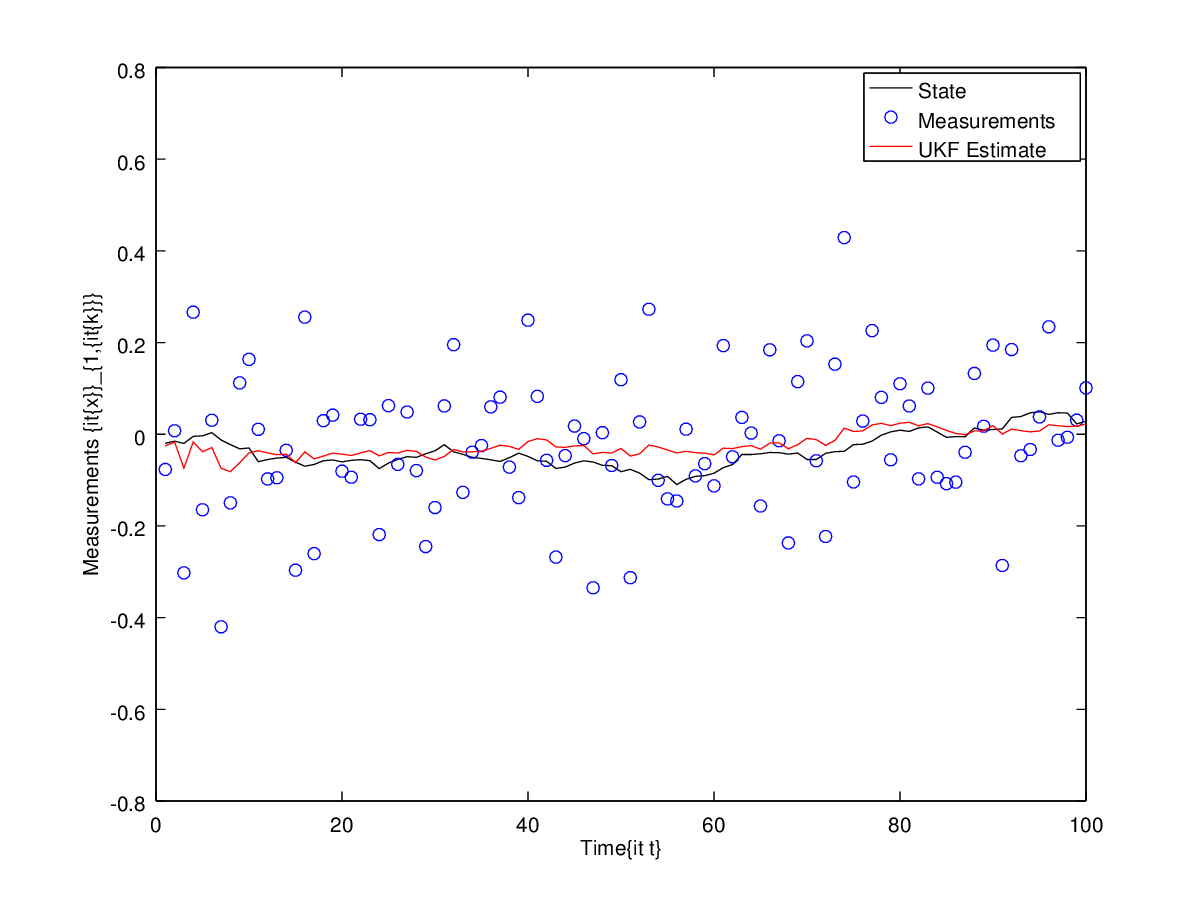

In [2]:
Image(filename='R4_1_UKF.png', width=600) 

Method | RMSE
--- | --- 
UKF Solution | 0.025676

### Exercise 3. (Bearings Only Target Tracking with CKF and UKF)

Implement CKF and UKF to the bearings only target tracking model in Exercise 3 of Round 4. You can use the EKF/UKF toolbox, if you already implemented the methods earlier. Plot the results and compare RMSE values of the different methods.

### Exercise 3 Solution.

The following is the implementation of the Unscented Kalman Filter (UKF).

In [7]:
%%script octave
%% Generate data

  % Lock seed
  randn('state',123);

  % Implement RMSE (true and estimate)
  rmse = @(X,EST) sqrt(mean(sum((X-EST).^2)));
  
  % Create a bit curved trajectory and angle
  % measurements from two sensors
  S1 = [-1.5;0.5]; % Position of sensor 1
  S2 = [1;1];      % Position of sensor 2
  sd = 0.05;       % Standard deviation of measurements
  dt = 0.01;       % Sampling period
  x0 = [0;0;1;0];  % Initial state

  a = zeros(1,500);
  a(1,50:100)  = pi/2/51/dt + 0.01*randn(1,51);
  a(1,200:250) = pi/2/51/dt + 0.01*randn(1,51);
  a(1,350:400) = pi/2/51/dt + 0.01*randn(1,51);
  x = x0;
  t = 0;
  X = [];
  Theta = [];
  T = [];
  for i=1:500
    F = [0 0  1    0;...
         0 0  0    1;...
         0 0  0   a(i);...
         0 0 -a(i) 0];
    x = expm(F*dt)*x;
    y1 = atan2(x(2)-S1(2), x(1)-S1(1)) + sd * randn;
    y2 = atan2(x(2)-S2(2), x(1)-S2(1)) + sd * randn;
    t  = t + dt;
    X = [X x];
    T = [T t];
    Theta = [Theta [y1;y2]];
  end
  steps = size(Theta,2);


%% Dynamic model

  % Parameters of the dynamic model
  qc = 0.1;
  
  % This is the transition matrix
  A  = [1 0 dt 0;
        0 1 0 dt;
        0 0 1 0;
        0 0 0 1];

  % This is the process noise covariance
  Q = [qc*dt^3/3 0 qc*dt^2/2 0;
       0 qc*dt^3/3 0 qc*dt^2/2;
       qc*dt^2/2 0 qc*dt 0;
       0 qc*dt^2/2 0 qc*dt];
  
   
%% Baseline solution
   
  % Baseline solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST1.

  %if 0 %% <--- Uncomment to disable
  
  fprintf('Running base line solution.\n');
    
  % Initialize to true value
  m1 = x0;     
  EST1 = zeros(4,steps);
  
  % Set up figure
  figure(1); clf
  
  % Loop through steps
  for k=1:steps
      
    % Compute crossing of the measurements
    dx1 = cos(Theta(1,k));
    dy1 = sin(Theta(1,k));
    dx2 = cos(Theta(2,k));
    dy2 = sin(Theta(2,k));
    d = [dx1 dx2; dy1 dy2]\[S2(1)-S1(1);S2(2)-S1(2)];
    
    % Crossing
    cross_xy = S1 + [dx1;dy1]*d(1);
    
    % Compute estimate
    m1(3:4) = [0;0];
    m1(1:2) = cross_xy;
    EST1(:,k) = m1;
  end
    
  % Compute error
  err1 = rmse(X,EST1)

  % Plot baseline
  figure(1); clf

    plot(X(1,:),X(2,:),'--',...
         EST1(1,:),EST1(2,:),'-',...
         S1(1),S1(2),'kx',S2(1),S2(2),'ko')
    legend('True trajectory','Baseline estimate','Sensor 1','Sensor 2');
    xlabel('x'); ylabel('y'); title('\bf Baseline Solution')
    axis([-2 2 -2.5 1.5]);
 
%% UKF solution
  
  % UKF solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST2.
  
  %if 0 %% <--- Uncomment to disable

  fprintf('Running UKF solution.\n');

  m = x0;            % Initialize to true value
  P = eye(4);        % Some uncertainty
  R  = sd^2*eye(2);   % The joint covariance
  EST2 = zeros(4,steps);
  
  % Functions and their respective derivatives
 
  % This is the measurement function
  H = @(AA) [atan2(AA(2)-S1(2), AA(1)-S1(1)); ...
             atan2(AA(2)-S2(2), AA(1)-S2(1))];
         
    %
    % Precompute the UT weights
    %
    n = size(m,1);
    alpha = 1;
    beta = 0;
    kappa = 3-n;

    lambda = alpha^2 * (n + kappa) - n;        
    WM = zeros(2*n+1,1);
    WC = zeros(2*n+1,1);
    for j=1:2*n+1
        if j==1
            wm = lambda / (n + lambda);
            wc = lambda / (n + lambda) + (1 - alpha^2 + beta);
        else
            wm = 1 / (2 * (n + lambda));
            wc = wm;
        end
        WM(j) = wm;
        WC(j) = wc;
    end
    
  % Set up figure
  figure(1); clf
  
  % Loop through steps
  
  Ad = A;
  m = x0;            % Initialize to true value
  P = 0.1 * eye(4);        % Some uncertainty
  
    %
    % Do the filtering
    %  
    MM = zeros(size(m,1), size(Theta, 2));
    PP = zeros(size(P,1),size(P,2), size(Theta, 2));
    for k=1:steps

        % Form the sigma points for dynamic model
        A = chol(P,'lower');
        SX = [zeros(size(m)) A -A];
        SX = sqrt(n + lambda)*SX + repmat(m,1,size(SX,2));

        % Propagate through the dynamic model
        HX = Ad * SX;
  
        % Compute the predicted mean and covariance
        m = zeros(size(m));
        P = zeros(size(P));
        for i=1:size(HX,2)
            m = m + WM(i) * HX(:,i);
        end
        for i=1:size(HX,2)
            P = P + WC(i) * (HX(:,i) - m) * (HX(:,i) - m)';
        end
        P = P + Q;

        % Form sigma points for measurement step and
        % propagate throught the measurement model
        A = chol(P)';
        SX = [zeros(size(m)) A -A];
        SX = sqrt(n + lambda)*SX + repmat(m,1,size(SX,2));
        HY = [];
        for z = 1:size(SX, 2)
            HY = [HY H(SX(:, z))]; 
        end
    
        % Compute the updated mean and covariance
        mu = zeros(size(HY,1),1);
        S  = zeros(size(HY,1),size(HY,1));
        C  = zeros(size(SX,1),size(HY,1));
        for i=1:size(SX,2)
            mu = mu + WM(i) * HY(:,i);
        end
        for i=1:size(SX,2)
            S = S + WC(i) * (HY(:,i) - mu) * (HY(:,i) - mu)';
            C = C + WC(i) * (SX(:,i) - m) * (HY(:,i) - mu)';
        end
        S = S + R;
    
        % Compute the gain and updated mean and covariance  
        K = C/S;
        m = m + K*(Theta(:, k) - mu);
        P = P - K*S*K';
    
        MM(:,k) = m;
        PP(:,:,k) = P;
        m2 = m;
        EST2(:, k) = m2;
    end

  % Compute error
  err2 = rmse(X,EST2)
  
  % Plot UKF
  figure(1); clf

    plot(X(1,:),X(2,:),'--',...
         EST2(1,:),EST2(2,:),'-',...
         S1(1),S1(2),'kx',S2(1),S2(2),'ko')
    legend('True trajectory','UKF estimate','Sensor 1','Sensor 2');
    xlabel('x'); ylabel('y'); title('\bf UKF Solution')
    axis([-2 2 -2.5 1.5]);
    saveas(gcf,'R5_3_UKF.png')

%% CKF solution
  
  % CKF solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST2.
  
  %if 0 %% <--- Uncomment to disable

  fprintf('Running CKF solution.\n');
  R  = sd^2*eye(2);   % The joint covariance
  EST3 = zeros(4,steps);
  
  % Functions and their respective derivatives
 
  % This is the measurement function
  H = @(AA) [atan2(AA(2)-S1(2), AA(1)-S1(1)); ...
             atan2(AA(2)-S2(2), AA(1)-S2(1))];
  
  % Set up figure
  figure(1); clf
  
  % Precomputation of weights
  n = size(m,1);
  XI = sqrt(n) * [eye(n) -eye(n)];
  W  = ones(1,2*n)/(2*n);
  
  % Loop through steps
  
  m = x0;            % Initialize to true value
  P = 0.1 * eye(4);        % Some uncertainty
  
    %
    % Do the filtering
    %  
    
    MM = zeros(size(m,1), size(Theta, 2));
    PP = zeros(size(P,1),size(P,2), size(Theta, 2));
    for k=1:steps

        % Form the sigma points for dynamic model
        SX = repmat(m,1,size(XI,2)) + chol(P,'lower') * XI;

        % Propagate through the dynamic model
        HX = Ad * SX;
  
        % Compute the predicted mean and covariance
        m = zeros(size(m));
        P = zeros(size(P));
        for i=1:size(HX,2)
            m = m + W(i) * HX(:,i);
        end
        for i=1:size(HX,2)
            P = P + W(i) * (HX(:,i) - m) * (HX(:,i) - m)';
        end
        P = P + Q;

        % Form sigma points for measurement step and
        % propagate throught the measurement model
        SX = repmat(m,1,size(XI,2)) + chol(P,'lower') * XI;
        HY = [];
        for z = 1:size(SX, 2)
            HY = [HY H(SX(:, z))]; 
        end
    
        % Compute the updated mean and covariance
        mu = zeros(size(HY,1),1);
        S  = zeros(size(HY,1),size(HY,1));
        C  = zeros(size(SX,1),size(HY,1));
        for i=1:size(SX,2)
            mu = mu + W(i) * HY(:,i);
        end
        for i=1:size(SX,2)
            S = S + W(i) * (HY(:,i) - mu) * (HY(:,i) - mu)';
            C = C + W(i) * (SX(:,i) - m) * (HY(:,i) - mu)';
        end
        S = S + R;
    
        % Compute the gain and updated mean and covariance  
        K = C/S;
        m = m + K*(Theta(:, k) - mu);
        P = P - K*S*K';
    
        MM(:,k) = m;
        PP(:,:,k) = P;
        EST3(:, k) = m;
    end

  % Compute error
  err3 = rmse(X,EST3)
  
  % Plot CKF
  figure(1); clf

    plot(X(1,:),X(2,:),'--',...
         EST3(1,:),EST3(2,:),'-',...
         S1(1),S1(2),'kx',S2(1),S2(2),'ko')
    legend('True trajectory','CKF estimate','Sensor 1','Sensor 2');
    xlabel('x'); ylabel('y'); title('\bf CKF Solution')
    axis([-2 2 -2.5 1.5]);
    saveas(gcf,'R5_3_CKF.png')

GNU Octave, version 3.8.2
Copyright (C) 2014 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  For details, type 'warranty'.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at http://www.octave.org.

Please contribute if you find this software useful.
For more information, visit http://www.octave.org/get-involved.html

Read http://www.octave.org/bugs.html to learn how to submit bug reports.
For information about changes from previous versions, type 'news'.

Running base line solution.
err1 =  1.0194
Running UKF solution.
err2 =  0.42017
Running CKF solution.
err3 =  0.42017


Some output formats are not available.


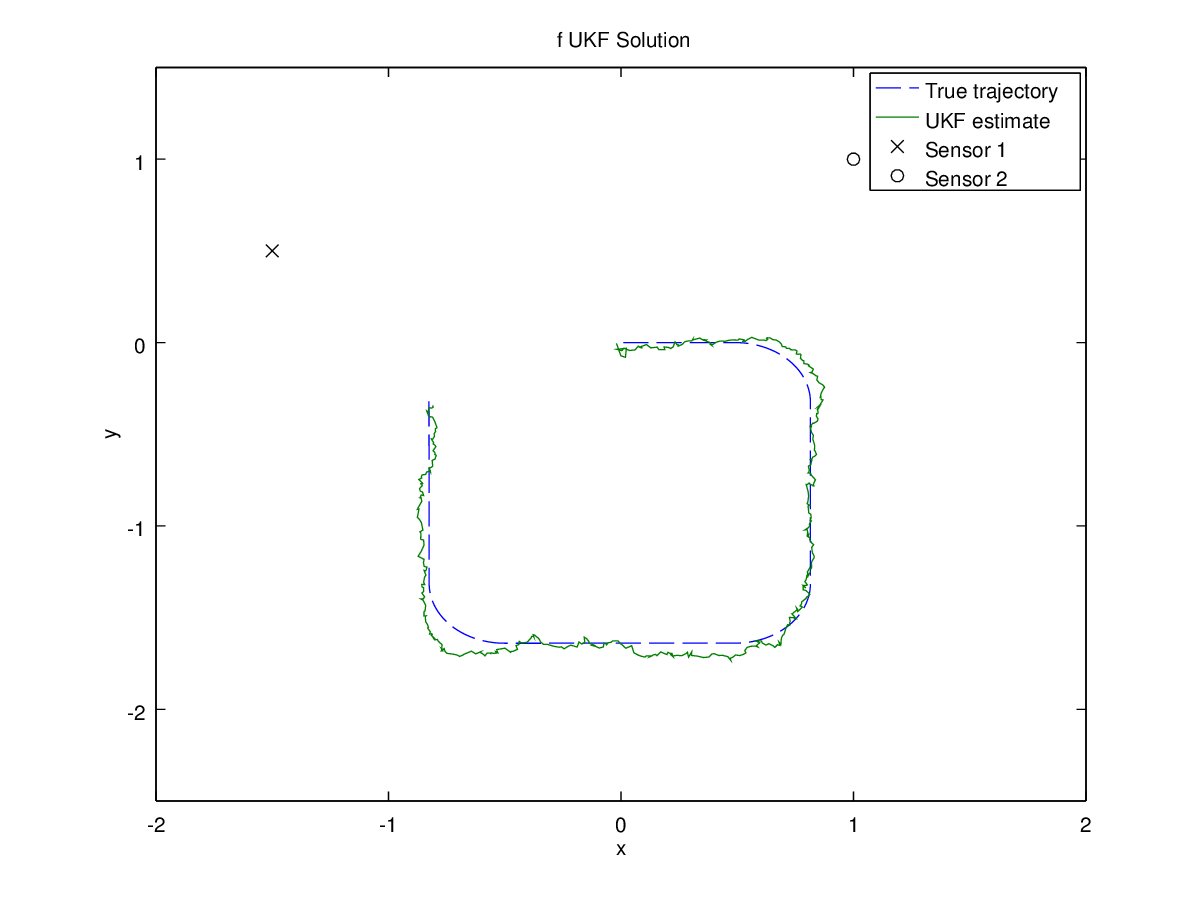

In [5]:
Image(filename='R5_3_UKF.png', width=500) 

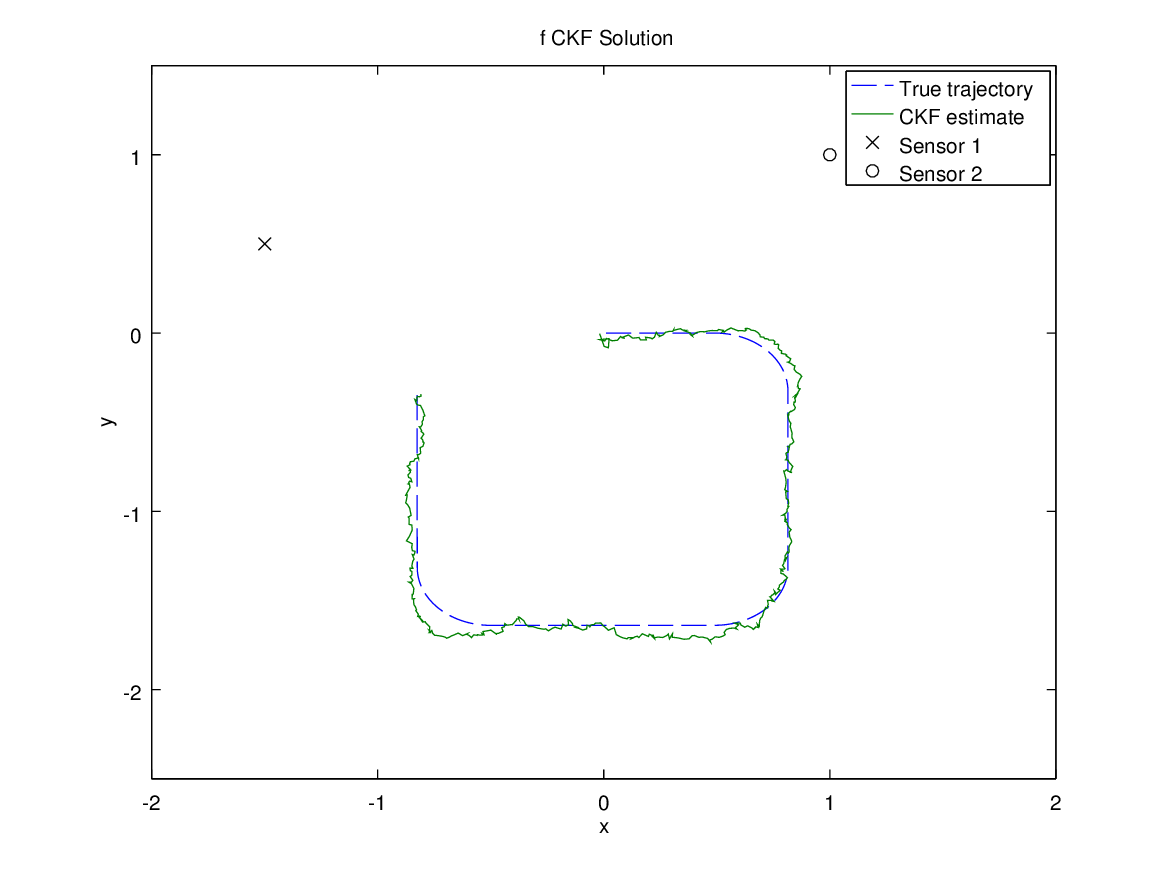

In [6]:
Image(filename='R5_3_CKF.png', width=500) 

Method | RMSE
--- | --- 
Baseline Solution | 1.0194
UKF Solution | 0.42017
CKF Solution | 0.42017